# Project

In [1]:
import os
import yaml
import pytimeloop.timeloopfe.v4 as tl
from pytimeloop.timeloopfe.common.nodes import DictNode
from pytimeloop.timeloopfe.v4.art import Art
from pytimeloop.timeloopfe.v4.ert import Ert
import shutil
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def run_timeloop_mapper(architecture, problem, constraints, mapper, config, output_dir):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
        
    spec = tl.Specification.from_yaml_files(architecture, problem, constraints, mapper, jinja_parse_data=config)

    result = tl.accelergy_app(spec, output_dir=output_dir)
    shutil.copy(output_dir + "/ART.yaml", output_dir + "/timeloop-mapper.ART.yaml")
    shutil.copy(output_dir + "/ERT.yaml", output_dir + "/timeloop-mapper.ERT.yaml")

    spec.ERT = Ert(**DictNode.from_yaml_files(output_dir + "/ERT.yaml")["ERT"])
    spec.ART = Art(**DictNode.from_yaml_files(output_dir + "/ART.yaml")["ART"])

    spec.ERT['tables'][0]['actions'][0]['energy'] = 0.0
    spec.ERT['tables'][0]['actions'][1]['energy'] = 0.0
    spec.ERT['tables'][0]['actions'][2]['energy'] = 0.0
    spec.ERT['tables'][0]['actions'][3]['energy'] = 0.0

    return tl.call_mapper(spec, output_dir=output_dir)

In [3]:
def run_data_parallel(problem, num_gpus, pe_array_size):
    desc = f"DP_{num_gpus}GPU_{pe_array_size}x{pe_array_size}_Layer{problem[-6]}"
    output_dir = f"./outputs/{desc}"
    
    result = run_timeloop_mapper(
        architecture='designs/system/arch.yaml',
        problem=problem,
        constraints='designs/system/constraints_dp.yaml',
        mapper='designs/_include/mapper.yaml',
        config={'gpu_meshX': num_gpus, 'pe_meshX': pe_array_size, 'pe_meshY': pe_array_size},
        output_dir=output_dir
    )

    print(desc, result.energy, result.cycles)
    
    return result

In [4]:
def run_tensor_parallel(problem, num_gpus, pe_array_size):
    desc = f"TP_{num_gpus}GPU_{pe_array_size}x{pe_array_size}_Layer{problem[-6]}"
    output_dir = f"./outputs/{desc}"
    
    result = run_timeloop_mapper(
        architecture='designs/system/arch.yaml',
        problem=problem,
        constraints='designs/system/constraints_tp.yaml',
        mapper='designs/_include/mapper.yaml',
        config={'gpu_meshX': num_gpus, 'pe_meshX': pe_array_size, 'pe_meshY': pe_array_size},
        output_dir=output_dir
    )
    
    print(desc, result.energy, result.cycles)
    
    return result

In [5]:
LAYERS = [
    'layer_shapes/alexnet/0.yaml',
    'layer_shapes/alexnet/1.yaml',
    'layer_shapes/alexnet/2.yaml',
    'layer_shapes/alexnet/3.yaml',
    'layer_shapes/alexnet/4.yaml',
    'layer_shapes/alexnet/5.yaml',
    'layer_shapes/alexnet/6.yaml',
    'layer_shapes/alexnet/7.yaml'
]

NUM_GPUS = [1,2,4,8,16,32,64,128]

PE_ARRAY_SIZES = [1,2,4,8,16,32]

### Data-Parallel

In [6]:
def get_result_data_parallel(problem, num_gpus, pe_array_size, all_gather=False):
    if all_gather:
        cache_path = f'cache/DP_{num_gpus}GPU_{pe_array_size}x{pe_array_size}_Layer{problem[-6]}_AG.pkl'
    else:
        cache_path = f'cache/DP_{num_gpus}GPU_{pe_array_size}x{pe_array_size}_Layer{problem[-6]}.pkl'
    try:
        result = pickle.load(open(cache_path, 'rb'))
        # print(f"Loaded result from cache: {cache_path}")
        return result
    except:
        pass

    os.makedirs('outputs', exist_ok=True)
    os.makedirs('cache', exist_ok=True)
    
    r = run_data_parallel(problem, num_gpus, pe_array_size)
    r.clear_zero_energies()

    if all_gather:
        parsed_processed_input = f"./outputs/DP_{num_gpus}GPU_{pe_array_size}x{pe_array_size}_Layer{problem[-6]}/parsed-processed-input.yaml"
        instance = yaml.safe_load(open(parsed_processed_input, 'r').read())['problem']['instance']
    
        num_hops = num_gpus - 1
        tensor_size = instance['N'] * instance['M'] * instance['P'] * instance['Q']
    
        # network energy from Ring AllGather (10 pJ/bit)
        network_energy = num_hops * tensor_size * 10e-12 * 16
    
        # network latency (utilizing full bandwidth of 100 GB/s)
        network_latency = (tensor_size / num_gpus) * num_hops * 2 / (100 * 1024 * 1024)
    
        r.per_component_energy["Network"] = network_energy

        result = {
            'energy': r.energy + network_energy,
            'per_component_energy': r.per_component_energy,
            'latency': network_latency if network_latency > r.latency else r.latency
        }
    else:
        result = {
            'energy': r.energy,
            'per_component_energy': r.per_component_energy,
            'latency': r.latency
        }
    
    pickle.dump(result, open(cache_path, 'wb'))
    print(f"Saved result to cache: {cache_path}")
    return result

### Tensor-Parallel

In [7]:
def get_result_tensor_parallel(problem, num_gpus, pe_array_size):
    cache_path = f'cache/TP_{num_gpus}GPU_{pe_array_size}x{pe_array_size}_Layer{problem[-6]}.pkl'
    try:
        result = pickle.load(open(cache_path, 'rb'))
        # print(f"Loaded result from cache: {cache_path}")
        return result
    except:
        pass

    os.makedirs('outputs', exist_ok=True)
    os.makedirs('cache', exist_ok=True)
    
    r = run_tensor_parallel(problem, num_gpus, pe_array_size)
    r.clear_zero_energies()

    parsed_processed_input = f"./outputs/TP_{num_gpus}GPU_{pe_array_size}x{pe_array_size}_Layer{problem[-6]}/parsed-processed-input.yaml"
    instance = yaml.safe_load(open(parsed_processed_input, 'r').read())['problem']['instance']

    num_hops = num_gpus - 1
    tensor_size = instance['N'] * instance['M'] * instance['P'] * instance['Q']

    # network energy from Ring AllGather (10 pJ/bit)
    network_energy = num_hops * tensor_size * 10e-12 * 16

    # network latency (utilizing full bandwidth of 100 GB/s)
    network_latency = (tensor_size / num_gpus) * num_hops * 2 / (100 * 1024 * 1024)

    r.per_component_energy["Network"] = network_energy
    
    result = {
        'energy': r.energy + network_energy,
        'per_component_energy': r.per_component_energy,
        'latency': network_latency if network_latency > r.latency else r.latency
    }
    
    pickle.dump(result, open(cache_path, 'wb'))
    print(f"Saved result to cache: {cache_path}")
    return result

### Analysis

<Axes: xlabel='AlexNet Layer', ylabel='Energy (J)'>

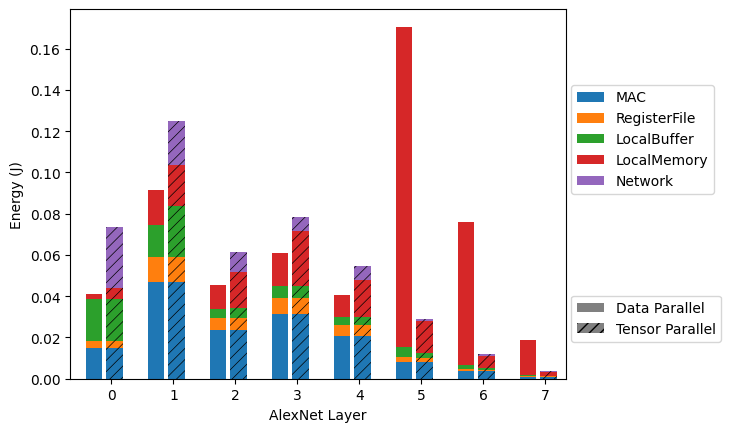

In [8]:
def plot_clustered_stacked(dfall, labels=None, xlabel="xlabel", ylabel="ylabel", H="///", **kwargs):
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall:
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)

    h,l = axe.get_legend_handles_labels()
    for i in range(0, n_df * n_col, n_col):
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches:
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col))
                rect.set_hatch_linewidth(0.5)
                rect.set_width(0.8 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_xlabel(xlabel)
    axe.set_ylabel(ylabel)

    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe


df1 = pd.DataFrame(np.zeros((8, 5)),
                   index=["0", "1", "2", "3", "4", "5", "6", "7"],
                   columns=["MAC", "RegisterFile", "LocalBuffer", "LocalMemory", "Network"])

df2 = pd.DataFrame(np.zeros((8, 5)),
                   index=["0", "1", "2", "3", "4", "5", "6", "7"],
                   columns=["MAC", "RegisterFile", "LocalBuffer", "LocalMemory", "Network"])

for problem in LAYERS:
    result = get_result_data_parallel(problem, 16, 16)
    for component, energy in result['per_component_energy'].items():
        df1.loc[problem[-6], component] = energy

for problem in LAYERS:
    result = get_result_tensor_parallel(problem, 16, 16)
    for component, energy in result['per_component_energy'].items():
        df2.loc[problem[-6], component] = energy

plot_clustered_stacked([df1, df2], ["Data Parallel", "Tensor Parallel"], "AlexNet Layer", "Energy (J)")

In [9]:
def get_dnn_stats_dp(num_gpus, pe_array_size):
    dnn_energy = 0
    dnn_latency = 0
    for problem in LAYERS:
        result = get_result_data_parallel(problem, num_gpus, pe_array_size)
        dnn_energy += result['energy']
        dnn_latency = max(dnn_latency, result['latency'])
    return dnn_energy, 64 / dnn_latency

def get_dnn_stats_tp(num_gpus, pe_array_size):
    dnn_energy = 0
    dnn_latency = 0
    for problem in LAYERS:
        result = get_result_tensor_parallel(problem, num_gpus, pe_array_size)
        dnn_energy += result['energy']
        dnn_latency = max(dnn_latency, result['latency'])
    return dnn_energy, 64 / dnn_latency

def get_dnn_stats_dp_tp(num_gpus, pe_array_size):
    dnn_energy = 0
    dnn_latency = 0
    for problem in LAYERS:
        if int(problem[-6]) < 4:
            result = get_result_data_parallel(problem, num_gpus, pe_array_size)
        elif int(problem[-6]) == 4:
            result = get_result_data_parallel(problem, num_gpus, pe_array_size, all_gather=True)
        else:
            result = get_result_tensor_parallel(problem, num_gpus, pe_array_size)
        dnn_energy += result['energy']
        dnn_latency = max(dnn_latency, result['latency'])
    return dnn_energy, 64 / dnn_latency

_, baseline_throughput = get_dnn_stats_dp(1, 16)
energy_dp, throughput_dp = get_dnn_stats_dp(16, 16)
energy_tp, throughput_tp = get_dnn_stats_tp(16, 16)
energy_dp_tp, throughput_dp_tp = get_dnn_stats_dp_tp(16, 16)

print("Energy, Speedup (DP):", energy_dp, throughput_dp / baseline_throughput)
print("Energy, Speedup (TP):", energy_tp, throughput_tp / baseline_throughput)
print("Energy, Speedup (DP+TP):", energy_dp_tp, throughput_dp_tp / baseline_throughput)

Energy, Speedup (DP): 0.5444872520858419 16.0
Energy, Speedup (TP): 0.43736195839299585 6.766810453333333
Energy, Speedup (DP+TP): 0.3303142522800128 16.0


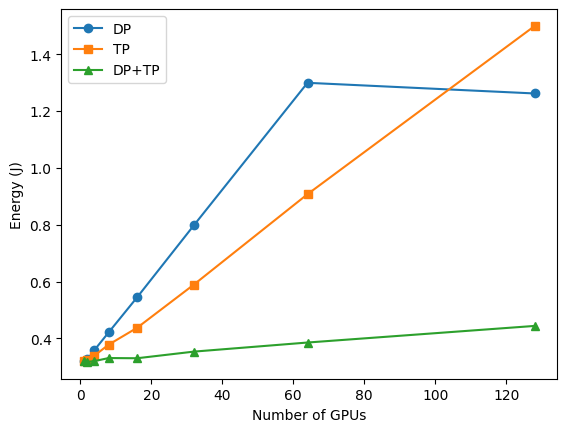

In [10]:
plt.plot(NUM_GPUS, [get_dnn_stats_dp(num_gpus, 16)[0] for num_gpus in NUM_GPUS], marker='o', label="DP")
plt.plot(NUM_GPUS, [get_dnn_stats_tp(num_gpus, 16)[0] for num_gpus in NUM_GPUS], marker='s', label="TP")
plt.plot(NUM_GPUS, [get_dnn_stats_dp_tp(num_gpus, 16)[0] for num_gpus in NUM_GPUS], marker='^', label="DP+TP")

plt.xlabel("Number of GPUs")
plt.ylabel("Energy (J)")
plt.legend()

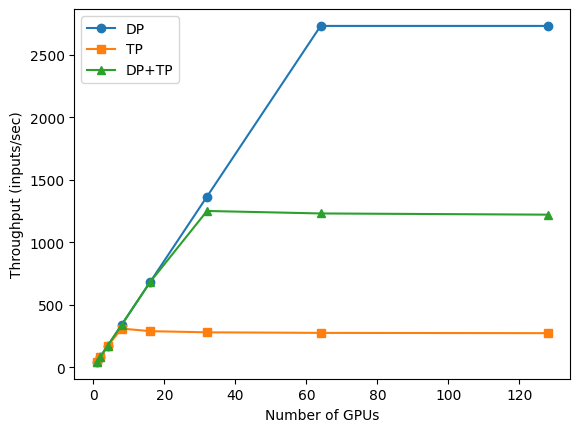

In [13]:
plt.plot(NUM_GPUS, [get_dnn_stats_dp(num_gpus, 16)[1] for num_gpus in NUM_GPUS], marker='o', label="DP")
plt.plot(NUM_GPUS, [get_dnn_stats_tp(num_gpus, 16)[1] for num_gpus in NUM_GPUS], marker='s', label="TP")
plt.plot(NUM_GPUS, [get_dnn_stats_dp_tp(num_gpus, 16)[1] for num_gpus in NUM_GPUS], marker='^', label="DP+TP")

plt.xlabel("Number of GPUs")
plt.ylabel("Throughput (inputs/sec)")
plt.legend()

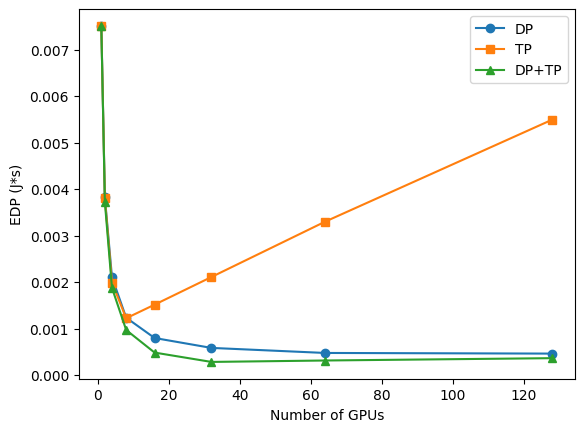

In [14]:
plt.plot(NUM_GPUS, [get_dnn_stats_dp(num_gpus, 16)[0] / get_dnn_stats_dp(num_gpus, 16)[1] for num_gpus in NUM_GPUS], marker='o', label="DP")
plt.plot(NUM_GPUS, [get_dnn_stats_tp(num_gpus, 16)[0] / get_dnn_stats_tp(num_gpus, 16)[1] for num_gpus in NUM_GPUS], marker='s', label="TP")
plt.plot(NUM_GPUS, [get_dnn_stats_dp_tp(num_gpus, 16)[0] / get_dnn_stats_dp_tp(num_gpus, 16)[1] for num_gpus in NUM_GPUS], marker='^', label="DP+TP")

plt.xlabel("Number of GPUs")
plt.ylabel("EDP (J*s)")
plt.legend()

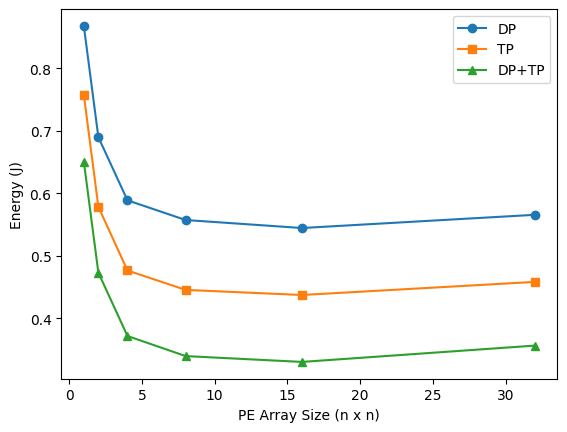

In [15]:
plt.plot(PE_ARRAY_SIZES, [get_dnn_stats_dp(16, pe_array_size)[0] for pe_array_size in PE_ARRAY_SIZES], marker='o', label="DP")
plt.plot(PE_ARRAY_SIZES, [get_dnn_stats_tp(16, pe_array_size)[0] for pe_array_size in PE_ARRAY_SIZES], marker='s', label="TP")
plt.plot(PE_ARRAY_SIZES, [get_dnn_stats_dp_tp(16, pe_array_size)[0] for pe_array_size in PE_ARRAY_SIZES], marker='^', label="DP+TP")

plt.xlabel("PE Array Size (n x n)")
plt.ylabel("Energy (J)")
plt.legend()

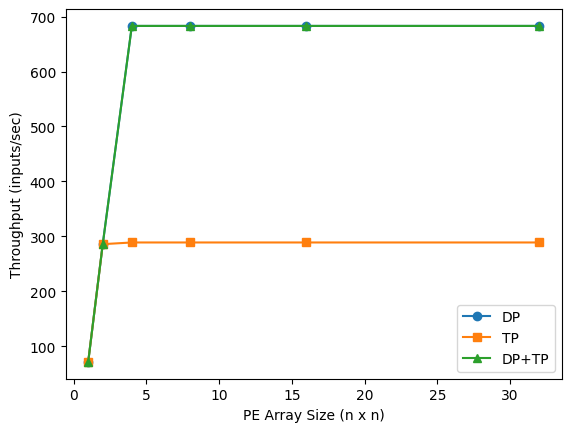

In [16]:
plt.plot(PE_ARRAY_SIZES, [get_dnn_stats_dp(16, pe_array_size)[1] for pe_array_size in PE_ARRAY_SIZES], marker='o', label="DP")
plt.plot(PE_ARRAY_SIZES, [get_dnn_stats_tp(16, pe_array_size)[1] for pe_array_size in PE_ARRAY_SIZES], marker='s', label="TP")
plt.plot(PE_ARRAY_SIZES, [get_dnn_stats_dp_tp(16, pe_array_size)[1] for pe_array_size in PE_ARRAY_SIZES], marker='^', label="DP+TP")

plt.xlabel("PE Array Size (n x n)")
plt.ylabel("Throughput (inputs/sec)")
plt.legend()

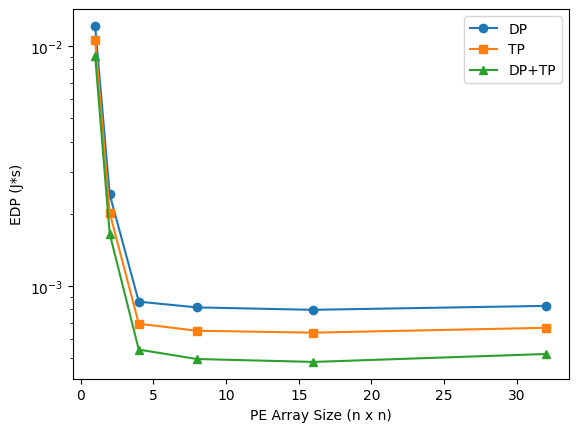

In [17]:
plt.plot(PE_ARRAY_SIZES, [get_dnn_stats_dp(16, pe_array_size)[0] / get_dnn_stats_dp(16, pe_array_size)[1] for pe_array_size in PE_ARRAY_SIZES], marker='o', label="DP")
plt.plot(PE_ARRAY_SIZES, [get_dnn_stats_tp(16, pe_array_size)[0] / get_dnn_stats_dp(16, pe_array_size)[1] for pe_array_size in PE_ARRAY_SIZES], marker='s', label="TP")
plt.plot(PE_ARRAY_SIZES, [get_dnn_stats_dp_tp(16, pe_array_size)[0] / get_dnn_stats_dp(16, pe_array_size)[1] for pe_array_size in PE_ARRAY_SIZES], marker='^', label="DP+TP")

plt.xlabel("PE Array Size (n x n)")
plt.ylabel("EDP (J*s)")
plt.legend()

plt.yscale('log')